We already did Cat vs Dog Classifier but this time, we will use Transfer Learning to do this and we will use already trained powerful Deep Learning architectures like VGG16

In our classifier model, we were able to acheive model accuracy of around 83%. Let us see how much this accuracy can be increased after implementing transfer learning.

## Step 1: Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

This library is used to import the dataset

In [2]:
(train_data, test_data), info = tfds.load('cats_vs_dogs',
                                          split=['train[:80%]', 'train[80%:]'],
                                          with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteOVHIJF/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


So, this is a supervised data set and we have split the dataset with 80% for train and 20% for test

In [4]:
info = tfds.builder('cats_vs_dogs').info
num_train_examples = info.splits['train[:80%]'].num_examples
num_test_examples = info.splits['train[80%:]'].num_examples

print("Number of examples in the training set:", num_train_examples)
print("Number of examples in the test set:", num_test_examples)

Number of examples in the training set: 18610
Number of examples in the test set: 4652


In [5]:
# Get class names and counts
class_names = info.features['label'].names
num_classes = len(class_names)

# Print class names and their corresponding counts
for class_index in range(num_classes):
    class_name = class_names[class_index]
    num_examples = info.splits['train'].num_examples // num_classes  # Assuming an equal split between classes
    print(f"Number of {class_name} examples:", num_examples)

Number of cat examples: 11631
Number of dog examples: 11631


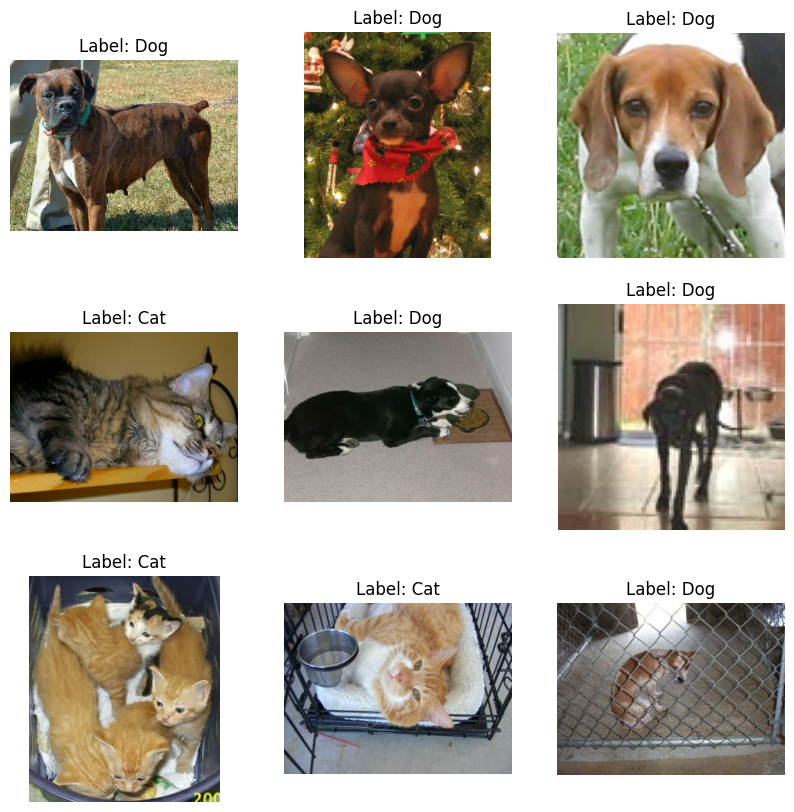

In [6]:
import matplotlib.pyplot as plt

# Function to show images with labels
def show_samples(dataset):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy())
        plt.title('Label: ' + ('Cat' if label.numpy() == 0 else 'Dog'))
        plt.axis('off')

# Displaying training samples
show_samples(train_data)
plt.show()


# Step 3: Preprocess the Data
Perform necessary preprocessing steps like resizing, normalization, etc.
Example:

In [7]:
def preprocess_img(image, label):
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0  # Cast image to float32 and normalize
    return image, label

IMG_SIZE = 256  # Define the desired image size
train_data = train_data.map(preprocess_img).shuffle(1000).batch(32)
test_data = test_data.map(preprocess_img).batch(32)


# Step 4: Using Transfer Learning VGG16 Model

We will use the convolution layer or the feature extraction layer of VGG16 model and use this knowledge for our use case.

In [9]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [16]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False, # means we do not want the last FCC and output layers from our dataset, only taking convolutional base
    input_shape=(256,256,3)
)

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

See, how we have 147 million parameters already trained to work with which is the best part of using transfer learning.

Creating a CNN architecture using this as conv_base, then we will use one Flatten layer and one Dense layer with 256 nodes and 1 output layer which will be having sigmoid activation function because we are working on binary classification problem.

In [18]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               8388864   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23103809 (88.13 MB)
Trainable params: 23103809 (88.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We will freeze the convolution layer because we don't need to train these parameters.

In [20]:
conv_base.trainable = False

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               8388864   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23103809 (88.13 MB)
Trainable params: 8389121 (32.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [22]:
# generators
train_ds = train_data

validation_ds = test_data

In [23]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
582/582 [==============================] - 156s 246ms/step - loss: 0.2559 - accuracy: 0.9031 - val_loss: 0.1535 - val_accuracy: 0.9355
Epoch 2/10
582/582 [==============================] - 139s 236ms/step - loss: 0.1277 - accuracy: 0.9471 - val_loss: 0.1473 - val_accuracy: 0.9379
Epoch 3/10
582/582 [==============================] - 122s 205ms/step - loss: 0.0815 - accuracy: 0.9688 - val_loss: 0.3006 - val_accuracy: 0.8953
Epoch 4/10
582/582 [==============================] - 139s 236ms/step - loss: 0.0650 - accuracy: 0.9744 - val_loss: 0.1740 - val_accuracy: 0.9359
Epoch 5/10
582/582 [==============================] - 121s 205ms/step - loss: 0.0438 - accuracy: 0.9833 - val_loss: 0.1903 - val_accuracy: 0.9392
Epoch 6/10
582/582 [==============================] - 120s 204ms/step - loss: 0.0314 - accuracy: 0.9882 - val_loss: 0.2276 - val_accuracy: 0.9325
Epoch 7/10
582/582 [==============================] - 139s 236ms/step - loss: 0.0333 - accuracy: 0.9866 - val_loss: 0.2849 -

Wow, definately there is a good improvement, val accuracy touching 93% from 83%.

So, this works really well.

But maybe because of having lesser data, it is getting overfit.

We can try some techniques like data augumentation to reduce overfitting.

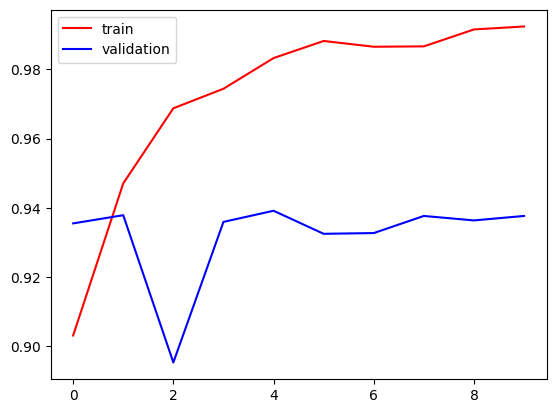

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

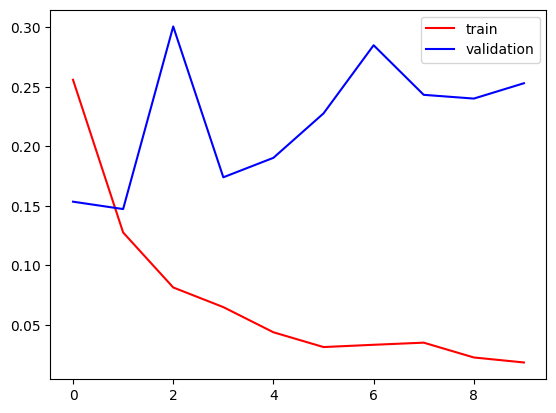

In [26]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()